# Image Classification with PyTorch and Datalab


This 5-minute quickstart tutorial demonstrates how to find potential label errors in image classification data. Here we use the MNIST dataset containing 70,000 images of handwritten digits from 0 to 9.

**Overview of what we'll do in this tutorial:**

- Build a simple [PyTorch](https://pytorch.org/) neural net and wrap it with [skorch](https://skorch.readthedocs.io/) to make it scikit-learn compatible.

- Use this model to compute out-of-sample predicted probabilities, `pred_probs`, via cross-validation.

- Compute a list of potential label errors with cleanlab's `Datalab` class.


<div class="alert alert-info">
Quickstart
<br/>
    
Already have a `model`? Run cross-validation to get out-of-sample `pred_probs` and then the code below to find any potential label errors in your dataset.


<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```python
from cleanlab import Datalab

lab = Datalab(data=your_dataset, label_name="column_name_of_labels")
lab.find_issues(pred_probs=your_pred_probs, issue_types={"label":{}})

lab.get_issues("label")
```
    
</div>
</div>

## 1. Install and import required dependencies


You can use `pip` to install all packages required for this tutorial as follows:

```ipython3
!pip install matplotlib torch torchvision skorch datasets
!pip install cleanlab[datalab]
# Make sure to install the version corresponding to this tutorial
# E.g. if viewing master branch documentation:
#     !pip install git+https://github.com/cleanlab/cleanlab.git
```

In [1]:
# Package installation (this cell is hidden from docs.cleanlab.ai).
# If running on Colab, may want to use GPU (select: Runtime > Change runtime type > Hardware accelerator > GPU)
# Package versions used: matplotlib==3.5.1 torch==1.11.0 skorch==0.11.0

dependencies = ["cleanlab", "matplotlib", "torch", "torchvision", "skorch", "datasets"]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install cleanlab  # for colab
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

# Suppress benign warnings: 
import warnings 
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

In [2]:
import torch
from torch import nn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from skorch import NeuralNetClassifier

In [3]:
# This (optional) cell is hidden from docs.cleanlab.ai 

import numpy as np 

SEED = 123  # for reproducibility 
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)

## 2. Fetch and scale the MNIST dataset


In [4]:
mnist = fetch_openml("mnist_784")  # Fetch the MNIST dataset

X = mnist.data.astype("float32").to_numpy() # 2D array (images are flattened into 1D)
X /= 255.0  # Scale the features to the [0, 1] range
X = X.reshape(len(X), 1, 28, 28)  # reshape into [N, C, H, W] for PyTorch

labels = mnist.target.astype("int64").to_numpy()  # 1D array of given labels

<div class="alert alert-info">
Bringing Your Own Data (BYOD)?

Assign your data's features to variable `X` and its labels to variable `labels` instead, and continue with the rest of the tutorial.

</div>

## 3. Define a classification model


Here, we define a simple neural network with PyTorch.


In [5]:
class ClassifierModule(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 6, 3),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=-1),
        )

    def forward(self, X):
        X = self.cnn(X)
        X = self.out(X)
        return X

## 4. Ensure your classifier is scikit-learn compatible


As some cleanlab features require scikit-learn compatibility, we adapt the above PyTorch neural net accordingly. [skorch](https://skorch.readthedocs.io) is a convenient package that helps with this. Alternatively, you can also easily wrap an arbitrary model to be scikit-learn compatible as demonstrated [here](https://github.com/cleanlab/cleanlab#use-cleanlab-with-any-model-for-most-ml-tasks).

In [6]:
model_skorch = NeuralNetClassifier(ClassifierModule)

## 5. Compute out-of-sample predicted probabilities


If we'd like cleanlab to identify potential label errors in the whole dataset and not just the training set, we can consider using the entire dataset when computing the out-of-sample predicted probabilities, `pred_probs`, via cross-validation.


In [7]:
num_crossval_folds = 3  # for efficiency; values like 5 or 10 will generally work better
pred_probs = cross_val_predict(
    model_skorch,
    X,
    labels,
    cv=num_crossval_folds,
    method="predict_proba",
)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6908       0.9134        0.3098  4.3110
      2        0.2112       0.9412        0.1999  4.2180
      3        0.1520       0.9516        0.1575  4.3448
      4        0.1239       0.9596        0.1333  4.2167
      5        0.1066       0.9635        0.1180  4.1936
      6        0.0948       0.9661        0.1072  4.1913
      7        0.0860       0.9683        0.0995  4.2037
      8        0.0792       0.9700        0.0934  4.2598
      9        0.0737       0.9727        0.0887  4.1957
     10        0.0691       0.9739        0.0846  4.2233
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7043       0.9248        0.2787  4.3258
      2        0.1906       0.9466        0.1816  4.2416
      3        0.1355       0.9560        0.1477  4.2692
      4        0.1100       0.9

An additional benefit of cross-validation is that it facilitates more reliable evaluation of our model than a single training/validation split.

In [8]:
predicted_labels = pred_probs.argmax(axis=1)
acc = accuracy_score(labels, predicted_labels)
print(f"Cross-validated estimate of accuracy on held-out data: {acc}")

Cross-validated estimate of accuracy on held-out data: 0.9752714285714286


## 6. Use cleanlab to find label issues


Based on the given labels and out-of-sample predicted probabilities, cleanlab can quickly help us identify label issues in our dataset. 

Here, we use cleanlab's `Datalab` to find potential label errors in our data. `Datalab` has several ways of loading the data. In this case, we’ll simply wrap the training features and noisy labels in a dictionary. We can instantiate our `Datalab` object with the dictionary created, and then pass in the model predicted probabilities we obtained above, and specify that we want to look for label errors by specifying that using the `issue_types` argument.

In [9]:
from cleanlab import Datalab

data = {"X": X, "y": labels}

lab = Datalab(data, label_name="y")
lab.find_issues(pred_probs=pred_probs, issue_types={"label":{}})

Finding label issues ...
Audit complete. 141 issues found in the dataset.


After the audit is complete, we can view the results and information regarding the labels using Datalab's `get_issues` method.

In [28]:
issue_results = lab.get_issues("label")
issue_results.head()

,is_label_issue,label_score,given_label,predicted_label
0,False,0.836702,5,5
1,False,0.999815,0,0
2,False,0.992262,4,4
3,False,0.997803,1,1
4,False,0.989576,9,9


The dataframe above contains a label quality score for each example. These numeric scores lie between 0 and 1, where lower scores indicate examples more likely to be mislabeled. It contains a boolean column specifying whether or not each example is identified to have a label issue (indicating it is likely mislabeled).

We can sort the results obtained by label score to find the indices of the 15 most likely mislabeled examples in our dataset.

In [54]:
ranked_label_issues = issue_results.sort_values("label_score").index

print(f"Top 15 most likely label errors: \n {ranked_label_issues.values[:15]}")

Top 15 most likely label errors: 
 [59915 24798 19124 53216  2720  8200 59701 50340 21601  2676 32776 56014
 35480 46726  7010]


`ranked_label_issues` is a list of indices ranked by the label score of each example, the top indices in the list corresponding to examples that are worth inspecting more closely. To help visualize specific examples, we define a `plot_examples` function (can skip these details).

<details><summary>See the implementation of `plot_examples` **(click to expand)**</summary>

```python
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

import matplotlib.pyplot as plt

def plot_examples(id_iter, nrows=1, ncols=1):
    for count, id in enumerate(id_iter):
        plt.subplot(nrows, ncols, count + 1)
        plt.imshow(X[id].reshape(28, 28), cmap="gray")
        plt.title(f"id: {id} \n label: {y[id]}")
        plt.axis("off")

    plt.tight_layout(h_pad=2.0)
```
</details>

In [11]:
import matplotlib.pyplot as plt

def plot_examples(id_iter, nrows=1, ncols=1):
    for count, id in enumerate(id_iter):
        plt.subplot(nrows, ncols, count + 1)
        plt.imshow(X[id].reshape(28, 28), cmap="gray")
        plt.title(f"id: {id} \n label: {labels[id]}")
        plt.axis("off")

    plt.tight_layout(h_pad=2.0)

Let's look at the top 15 examples cleanlab thinks are most likely to be incorrectly labeled. We can see a few label errors and odd edge cases. Feel free to change the values below to display more/fewer examples.

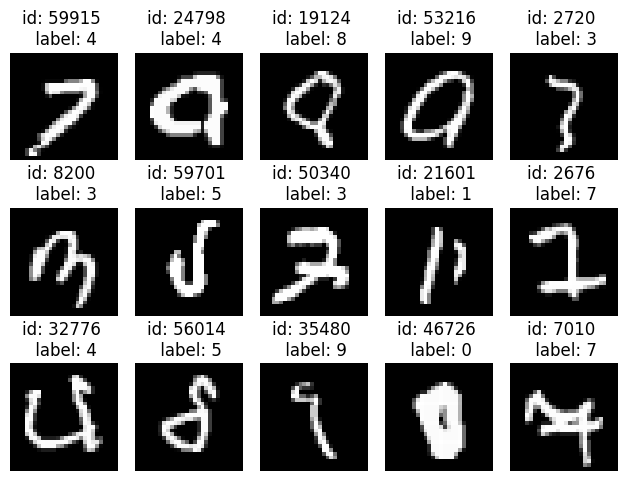

In [59]:
plot_examples(ranked_label_issues[range(15)], 3, 5)

Let's zoom into some specific examples from the above set:

Given label is **4** but looks more like a **7**:


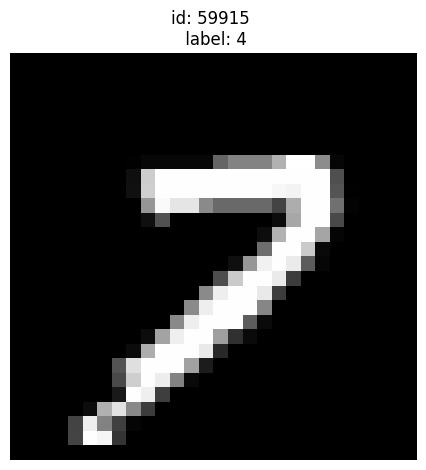

In [13]:
plot_examples([59915])

Given label is **4** but also looks like **9**:


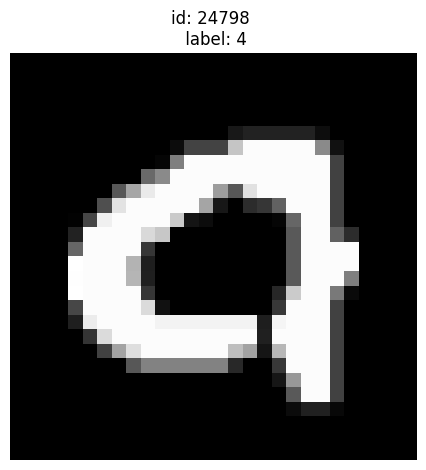

In [14]:
plot_examples([24798])

A very odd looking **5**:


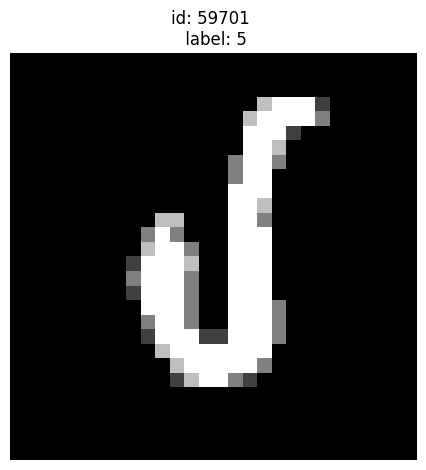

In [15]:
plot_examples([59701])

Given label is **3** but could be a **7**:

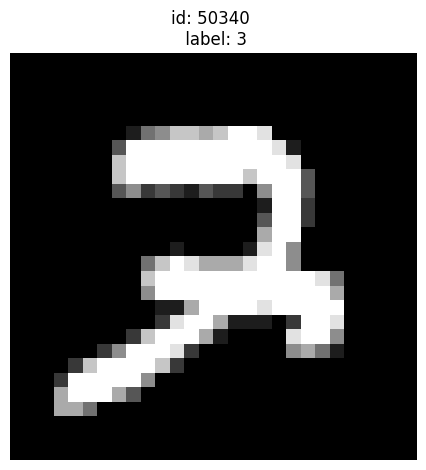

In [16]:
plot_examples([50340])

cleanlab has shortlisted the most likely label errors to speed up your data cleaning process. With this list, you can decide whether to fix label issues or prune some of these examples from the dataset. 

You can see that even widely-used datasets like MNIST contain problematic labels. Never blindly trust your data! You should always check it for potential issues, many of which can be easily identified by cleanlab.


In [17]:
# Note: This cell is only for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

highlighted_indices = [59915, 24798, 59701, 50340]  # verify these examples were found by cleanlab
if not all(x in ranked_label_issues for x in highlighted_indices):
    raise Exception("Some highlighted examples are missing from ranked_label_issues.")